In [85]:
# Import necessary libraries
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import math
import pickle
import copy

#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
#metrics and plotting
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
#other
from datasplit import get_datasplit
from featurescaling import scale_features


In [ ]:
#load adjacency and feature matrix generated in Feature_Generation.ipynb
with open("ligand_adjacency_and_Feature_Matrices.pkl", "rb") as g:
    df_gnn = pickle.load(g)

In [14]:
#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value


In [26]:
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

In [8]:
def check_shapes(row):
    A = row["adjacency_kipf"]
    X = row["feature_matrix"]
    if (A is None) or (X is None):
        return True
    return A.shape[0] == A.shape[1] == (X.shape[0] if hasattr(X, "shape") else len(X))
ok = df_gnn.apply(check_shapes, axis=1).all()
print(f"Adjacency/feature shapes aligned for all rows: {ok}")


first_feat = next((fm for fm in df_gnn["feature_matrix"] if fm is not None), None)
assert first_feat is not None, "No valid feature_matrix found."
in_features = int(np.asarray(first_feat).shape[1])

print(f"Number of input features per atom: {in_features}")
print(first_feat.shape)

Adjacency/feature shapes aligned for all rows: True
Number of input features per atom: 30
(11, 30)


Graph Convolution Class

In [9]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features)) #creates a randomly initialized weight matrix to be learned
        self.reset_parameters() # initializes the weight matrix

    def forward(self, x, adj): # x is the feature matrix, adj is the adjacency matrix
        aggregated_nodes = adj@x # @ is a shorthand for torch.mm() matrix multiplication of the adjacency with the feature matrix
        return aggregated_nodes@self.W # matrix multiplication with the learnable weight matrix

    def reset_parameters(self): 
        stdv = 1. / math.sqrt(self.W.size(1))
        self.W.data.uniform_(0, stdv) 

    def __repr__(self): 
        return self.__class__.__name__ + ' (' \
               + 'in_features=' + str(self.in_features) + ', ' \
               + 'out_features=' + str(self.out_features) + ')'

In [10]:
class GraphNN(nn.Module):
    # allow the sizes to be defined at initialization
    def __init__(self, in_features, out_features, hidden_features, dropout):
        super().__init__()
        self.conv1 = GraphConvolution(in_features, hidden_features)######..kpkp+j
        self.dropout = nn.Dropout(dropout)
        self.conv2 = GraphConvolution(hidden_features, hidden_features)
        self.output = nn.Linear(hidden_features, out_features)

    def aggregate(self, convoluted_graph):
        return torch.mean(convoluted_graph, dim=0, keepdim=True) 

    def forward(self, x, adj):
        x = F.relu(self.conv1(x, adj))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, adj))
        x = self.aggregate(x)
        x = self.output(x)
        return x

In [62]:
df_gnn# Choose output embedding size and hidden size
ligand_emb_dim = 100
hidden_dim = 100
dropout = 0.1

gnn = GraphNN(in_features=in_features, out_features=ligand_emb_dim,
              hidden_features=hidden_dim, dropout=dropout)
gnn.eval()

GraphNN(
  (conv1): GraphConvolution (in_features=30, out_features=100)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv2): GraphConvolution (in_features=100, out_features=100)
  (output): Linear(in_features=100, out_features=100, bias=True)
)

In [72]:
# Compute ligand embeddings
def compute_ligand_emb(X, A):
    """X: [N,F], A: [N,N] → returns [ligand_emb_dim] or None"""
    if X is None or A is None:
        return None
    x_t = torch.as_tensor(np.asarray(X), dtype=torch.float32)  # [N, F]
    a_t = torch.as_tensor(np.asarray(A), dtype=torch.float32)  # [N, N]
    z = gnn(x_t, a_t)                                         # [1, D]  
    return z.squeeze_(0).detach().numpy()                        # [D]

df_gnn["ligand_emb"] = [
    compute_ligand_emb(X, A)
    for X, A in zip(df_gnn["feature_matrix"], df_gnn["adjacency_kipf"])
]

In [87]:
# join the dataframes for target variable an the gnn information

df = pd.merge(df_target_value, df_gnn, on="ligand", how="left") 
df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_ascii")
df_all = pd.merge(df, df_kinase, on="kinase", how="left")  

if "orig_idx" not in df_all.columns:
    df_all = df_all.reset_index(drop=False).rename(columns={"index": "orig_idx"})



In [ ]:
import ast

#hilfsfunktionen
def to_numeric_1d(x):
    # parse stringified lists
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return None
    arr = np.asarray(x, dtype=np.float32)
    arr = np.atleast_1d(arr).ravel()  # ensure 1-D
    if arr.size == 0:
        return None
    return arr

def row_to_feature(row):
    z = row.get("ligand_emb", None)
    #label-slice
    p = row.loc["0":"84"]
    # convert/validate
    z_arr = to_numeric_1d(z)
    p_arr = to_numeric_1d(p)
    if z_arr is None or p_arr is None:
        return np.nan  # consistent missing marker for .notna()
    # final concatenation
    try:
        return np.concatenate([z_arr, p_arr], axis=0)
    except Exception as e:
        # if shapes are weird, return nan 
        print(f"concat failed: z.shape={getattr(z_arr,'shape',None)} p.shape={getattr(p_arr,'shape',None)} -> {e}")
        return np.nan

df_all["features_concat"] = df_all.apply(row_to_feature, axis=1)

# Filter to rows that have everything
mask_ok = df_all["features_concat"].notna() & df_all["log_koff"].notna()  # change to k_off if needed
df_ready = df_all.loc[mask_ok].copy()

# ensure every element is array-like 
feats = [f for f in df_ready["features_concat"].to_list() if (isinstance(f, (list, np.ndarray)) and np.asarray(f).ndim >= 1)]
if len(feats) != len(df_ready): #check if same dimensions
    bad = df_ready[~df_ready["features_concat"].apply(lambda x: isinstance(x, (list, np.ndarray)))] #shows offending rows
    print(f"Dropped {len(df_ready)-len(feats)} rows due to bad features. Example rows:\n", bad.head(3))
X = np.vstack(feats).astype(np.float32)
y = df_ready["log_koff"].to_numpy().astype(np.float32)

print(f"Feature dim = {X.shape[1]}  |  n_samples = {X.shape[0]}")

Feature dim = 185  |  n_samples = 3177


In [77]:
#get iris split from my cleaned data set
df_train = df_ready[df_ready.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_ready[df_ready.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test= df_ready[df_ready.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_ready[df_ready.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()

Feature Scaling

In [69]:
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def parse_feature_cell(x):
    # handle None / nan
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    # if already numeric array / list
    if isinstance(x, (list, tuple, np.ndarray)):
        arr = np.asarray(x, dtype=float)
        return np.atleast_1d(arr).ravel() if arr.size > 0 else None
    return None

# parse column into list of 1D arrays and keep original index
parsed = df_train["features_concat"].apply(parse_feature_cell)
X_features = np.vstack(parsed.values, )


# now fit scalers safely
y_raw = df_train["log_koff"].values.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y_raw)

x_scaler = MinMaxScaler()
x_scaler.fit(X_features)

MinMaxScaler()

Prepare Tensors

In [82]:
#function to prepare tensors from dataframe
def prepare_tensors(df, y_scaler, x_scaler):
    parsed = df["features_concat"].apply(parse_feature_cell)
    keep = ~parsed.isna()
    X = np.vstack(parsed[keep].tolist())
    X_scaled = x_scaler.transform(X)
    
    y = df.loc[keep, "log_koff"].to_numpy(np.float32).reshape(-1,1)
    y_scaled = y_scaler.transform(y)
    
    
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32) # Konvertieren in Tensoren
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)


# Split des Datensets in test und training data. Hhange former holdout to the final test set, change former test set to validation set
train_ds = prepare_tensors(df_train, y_scaler=y_scaler, x_scaler=x_scaler)
test_ds = prepare_tensors(df_test, y_scaler=y_scaler, x_scaler=x_scaler)
val_ds = prepare_tensors(df_val, y_scaler=y_scaler, x_scaler=x_scaler)
holdout_ds = prepare_tensors(df_holdout, y_scaler=y_scaler, x_scaler=x_scaler)

#create minibatches of the specified size
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#how to access the tensor shapes if needed
X_tensor = train_ds.tensors[0]
y_tensor = train_ds.tensors[1]
X_test = test_ds.tensors[0]
y_test = test_ds.tensors[1]


In [83]:
#Training on the original data
dropout_ratio=0.3 #0.3
class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(in_len, 256) #256 
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(256, 128) #256, 128
        self.output   = nn.Linear(128, out_len) #128

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x)) #relu
        x = self.dropout2(x)
        x = F.relu(self.layer2(x)) #relu
        return self.output(x)

#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
model = NN_regression(in_len=X_tensor.shape[1]).to(device) #size of the input layer 185
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #default learning rate is 0.001
loss_fn = nn.MSELoss()

#training Loop
n_epochs = 100
train_losses, val_losses = [], []  # Liste zur Speicherung der avg_loss pro Epoche

#early stopper
#early_stopper = EarlyStopper(patience=20, min_delta=0.0001) #standard min_delta is 0.001
best_weights = copy.deepcopy(model.state_dict()) #save initial weights
best_val_loss = float('inf') #initialize best val loss to infinity


for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Loss speichern


     # validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    #track best model weights
    if avg_val_loss < best_val_loss: #-early_stopper.min_delta:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_loss:.4f}")
    
    #early stopping check
    #if early_stopper.early_stop(avg_val_loss):
     #   print(f"Early stopping triggered at epoch {epoch+1}.")
      #  break
#load best model weights after training
model.load_state_dict(best_weights)

# FINAL TEST EVALUATION (once)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        test_loss += loss_fn(pred, yb).item()
avg_test_loss = test_loss / len(test_loader)
print(f"Final TEST loss: {avg_test_loss:.4f}")


Epoch 1/100, Train Loss: 0.0448
Epoch 2/100, Train Loss: 0.0231
Epoch 3/100, Train Loss: 0.0228
Epoch 4/100, Train Loss: 0.0221
Epoch 5/100, Train Loss: 0.0228
Epoch 6/100, Train Loss: 0.0219
Epoch 7/100, Train Loss: 0.0218
Epoch 8/100, Train Loss: 0.0206
Epoch 9/100, Train Loss: 0.0197
Epoch 10/100, Train Loss: 0.0224
Epoch 11/100, Train Loss: 0.0195
Epoch 12/100, Train Loss: 0.0218
Epoch 13/100, Train Loss: 0.0199
Epoch 14/100, Train Loss: 0.0203
Epoch 15/100, Train Loss: 0.0213
Epoch 16/100, Train Loss: 0.0207
Epoch 17/100, Train Loss: 0.0256
Epoch 18/100, Train Loss: 0.0200
Epoch 19/100, Train Loss: 0.0202
Epoch 20/100, Train Loss: 0.0214
Epoch 21/100, Train Loss: 0.0200
Epoch 22/100, Train Loss: 0.0212
Epoch 23/100, Train Loss: 0.0198
Epoch 24/100, Train Loss: 0.0190
Epoch 25/100, Train Loss: 0.0193
Epoch 26/100, Train Loss: 0.0199
Epoch 27/100, Train Loss: 0.0212
Epoch 28/100, Train Loss: 0.0194
Epoch 29/100, Train Loss: 0.0187
Epoch 30/100, Train Loss: 0.0186
Epoch 31/100, Train


Test MSE: 0.5597 |Test R²: 0.2706 | Train R²: 0.3075 | Val R²: 0.2549| Holdout R2: 0.1137 | best epoch 100


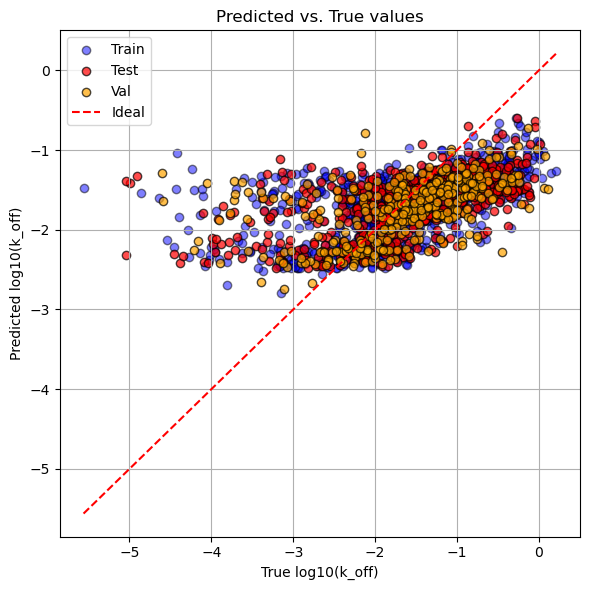

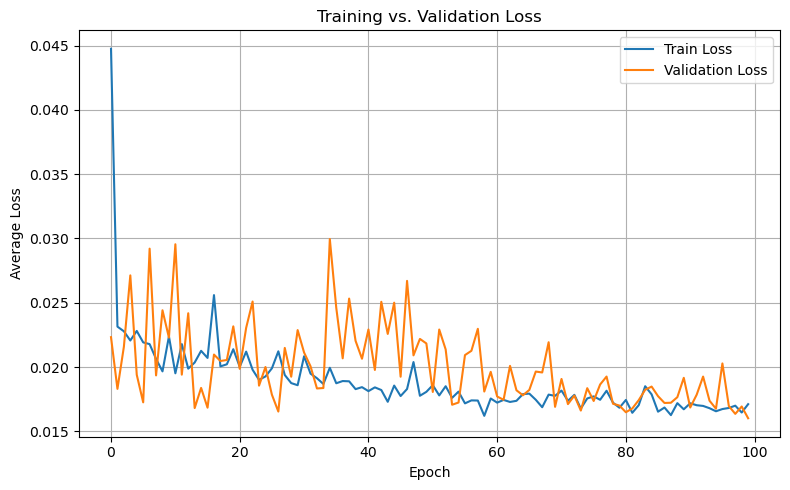

In [86]:

# evaluierung
model.eval()
with torch.no_grad():
    #test predictions

    y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

    # Train Predictions
    y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())
    
    #validation predictions
    y_val_pred_scaled=model(val_ds.tensors[0]).numpy()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = y_scaler.inverse_transform(val_ds.tensors[1].numpy())
    
    #validation predictions
    y_holdout_pred_scaled=model(holdout_ds.tensors[0]).numpy()
    y_holdout_pred = y_scaler.inverse_transform(y_holdout_pred_scaled)
    y_holdout_true = y_scaler.inverse_transform(holdout_ds.tensors[1].numpy())
    
    


mse = mean_squared_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
r2_train = r2_score(y_train_true, y_train_pred)
r2_val = r2_score(y_val_true, y_val_pred)
r2_holdout = r2_score(y_holdout_true, y_holdout_pred)

print(f"\nTest MSE: {mse:.4f} |Test R²: {r2:.4f} | Train R²: {r2_train:.4f} | Val R²: {r2_val:.4f}| Holdout R2: {r2_holdout:.4f} | best epoch { np.argmin(val_losses) + 1}")

#scatter plot of predicted vs true values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', color='blue', edgecolors='k')
plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='red', edgecolors='k')
plt.scatter(y_val_true, y_val_pred,  alpha=0.7, label='Val', c='orange', edgecolors='k')
min_val = min(y_train_true.min(), y_test_true.min())
max_val = max(y_train_true.max(), y_test_true.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel("True log10(k_off)")
plt.ylabel("Predicted log10(k_off)")
plt.title("Predicted vs. True values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#plot der training + validation losse

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(val_losses, label="Validation Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()